# 📊 Exploração de Dados - Dataset Soja e Milho

**Objetivo:** Análise exploratória completa do dataset `soja_milho.csv` com foco em medidas de tendência central, detecção de outliers e análise de correlações.

**Dataset:** `soja_milho.csv` - Preços históricos de soja e milho

**Nota:** As variáveis 'Mês' e 'Safra' são tratadas como categóricas, pois representam partes da data (mês do ano e ano/safra respectivamente).


## 📋 Índice do Notebook

### **[1. Importação das Bibliotecas Necessárias](#1-importação-das-bibliotecas-necessárias)**
### **[2. Carregamento e Primeira Inspeção dos Dados](#2-carregamento-e-primeira-inspeção-dos-dados)**
### **[3. Análise de Qualidade dos Dados](#3-análise-de-qualidade-dos-dados)**
### **[4. Análise Descritiva e Medidas de Tendência Central](#4-análise-descritiva-e-medidas-de-tendência-central)**
### **[5. Visualizações das Medidas de Tendência Central](#5-visualizações-das-medidas-de-tendência-central)**
### **[6. Análise de Espalhamento e Detecção de Outliers](#6-análise-de-espalhamento-e-detecção-de-outliers)**
- **[6.1 Análise Univariada de Outliers](#61-análise-univariada-de-outliers)**: Box plots e detecção IQR
- **[6.2 Análise Multivariada de Outliers - Bag Plot](#62-análise-multivariada-de-outliers---bag-plot)**: Distâncias de Mahalanobis
### **[7. Análise de Correlação e Covariância](#7-análise-de-correlação-e-covariância)**
### **[8. Resumo e Conclusões](#8-resumo-e-conclusões)**
### **[9. Informações Técnicas do Notebook](#9-informações-técnicas-do-notebook)**

---


## 1. Importação das Bibliotecas Necessárias


In [1]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr
from sklearn.covariance import MinCovDet
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Verificar versões das bibliotecas
print("📚 BIBLIOTECAS IMPORTADAS COM SUCESSO!")
print("=" * 50)
print(f"📊 Pandas: {pd.__version__}")
print(f"🔢 NumPy: {np.__version__}")
print(f"📈 Matplotlib: {plt.matplotlib.__version__}")
print(f"🎨 Seaborn: {sns.__version__}")


📚 BIBLIOTECAS IMPORTADAS COM SUCESSO!
📊 Pandas: 1.4.3
🔢 NumPy: 1.24.4
📈 Matplotlib: 3.7.2
🎨 Seaborn: 0.12.2


## 2. Carregamento e Primeira Inspeção dos Dados


In [2]:
# Carregamento do dataset com tratamento de codificação
def load_dataset(file_path):
    """
    Carrega o dataset com tratamento de diferentes codificações
    """
    encodings = ['utf-8', 'latin-1', 'cp1252', 'iso-8859-1']
    
    for encoding in encodings:
        try:
            df = pd.read_csv(file_path, encoding=encoding)
            print(f"✅ Dataset carregado com sucesso usando codificação: {encoding}")
            return df
        except UnicodeDecodeError:
            continue
        except Exception as e:
            print(f"❌ Erro ao carregar com {encoding}: {e}")
            continue
    
    print("❌ Não foi possível carregar o dataset com nenhuma codificação testada")
    return None

# Carregar o dataset
file_path = 'soja_milho.csv'
df = load_dataset(file_path)

if df is not None:
    print("\n📊 PRIMEIRA INSPEÇÃO DO DATASET:")
    print("=" * 50)
    print(f"📏 Dimensões: {df.shape[0]} linhas × {df.shape[1]} colunas")
    print(f"\n📋 Colunas: {list(df.columns)}")
    print(f"\n📄 Primeiras 5 linhas:")
    print(df.head())
    print(f"\n📄 Últimas 5 linhas:")
    print(df.tail())
    print(f"\n📊 Informações gerais:")
    print(df.info())
else:
    print("❌ Dataset não carregado. Verifique o arquivo 'soja_milho.csv'")


✅ Dataset carregado com sucesso usando codificação: latin-1

📊 PRIMEIRA INSPEÇÃO DO DATASET:
📏 Dimensões: 498 linhas × 6 colunas

📋 Colunas: ['Observação', 'Data', 'Mes', 'Safra', 'Milho', 'Soja']

📄 Primeiras 5 linhas:
   Observação        Data  Mes  Safra  Milho   Soja
0           1  02/01/2014    1   2014  26.64  72.18
1           2  03/01/2014    1   2014  27.00  71.42
2           3  06/01/2014    1   2014  27.29  71.38
3           4  07/01/2014    1   2014  27.49  70.31
4           5  08/01/2014    1   2014  27.16  70.14

📄 Últimas 5 linhas:
     Observação        Data  Mes  Safra  Milho   Soja
493         494  22/12/2015   12   2015  36.23  78.61
494         495  23/12/2015   12   2015  36.26  78.21
495         496  28/12/2015   12   2015  36.29  77.59
496         497  29/12/2015   12   2015  36.55  78.55
497         498  30/12/2015   12   2015  36.83  78.07

📊 Informações gerais:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 6 column

## 3. Análise de Qualidade dos Dados


In [3]:
# Análise de qualidade dos dados
if df is not None:
    print("=" * 60)
    print("ANÁLISE DE QUALIDADE DOS DADOS")
    print("=" * 60)
    
    # Informações básicas
    print(f"\n📊 INFORMAÇÕES BÁSICAS:")
    print("-" * 40)
    print(f"  • Total de linhas: {df.shape[0]}")
    print(f"  • Total de colunas: {df.shape[1]}")
    print(f"  • Memória utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Análise de valores ausentes
    print(f"\n🔍 ANÁLISE DE VALORES AUSENTES:")
    print("-" * 40)
    missing_data = df.isnull().sum()
    missing_percent = (missing_data / len(df)) * 100
    
    missing_df = pd.DataFrame({
        'Coluna': missing_data.index,
        'Valores_Ausentes': missing_data.values,
        'Percentual': missing_percent.values
    })
    
    print(missing_df.to_string(index=False))
    
    if missing_data.sum() == 0:
        print("\n✅ Nenhum valor ausente encontrado!")
    else:
        print(f"\n⚠️  Total de valores ausentes: {missing_data.sum()}")
    
    # Identificar tipos de dados
    print(f"\n📋 TIPOS DE DADOS:")
    print("-" * 40)
    print(df.dtypes.to_string())
    
    # Identificar variáveis numéricas e categóricas
    # Excluir 'Observação' pois é índice dos registros
    # Tratar 'Mes' e 'Safra' como categóricas pois representam partes da data
    numeric_cols = ['Milho', 'Soja']  # Apenas preços são verdadeiramente numéricos
    categorical_cols = ['Data', 'Mes', 'Safra']  # Data, mês e safra são categóricas
    
    print(f"\n🔢 VARIÁVEIS NUMÉRICAS ({len(numeric_cols)}):")
    print("-" * 40)
    for col in numeric_cols:
        print(f"  • {col}")
    
    print(f"\n📝 VARIÁVEIS CATEGÓRICAS ({len(categorical_cols)}):")
    print("-" * 40)
    for col in categorical_cols:
        print(f"  • {col}")
    
    print(f"\nℹ️  OBSERVAÇÕES:")
    print("-" * 40)
    print(f"  • 'Observação' foi excluída da análise (é índice dos registros)")
    print(f"  • 'Mes' e 'Safra' são tratadas como categóricas (partes da data)")
    print(f"  • Apenas 'Milho' e 'Soja' são analisadas como variáveis numéricas")
    
    # Análise de duplicatas
    print(f"\n🔄 ANÁLISE DE DUPLICATAS:")
    print("-" * 40)
    duplicates = df.duplicated().sum()
    print(f"  • Linhas duplicadas: {duplicates}")
    
    if duplicates > 0:
        print(f"  • Percentual de duplicatas: {(duplicates/len(df)*100):.2f}%")
    else:
        print("  • ✅ Nenhuma linha duplicada encontrada")
    
    # Estatísticas descritivas para variáveis numéricas
    if len(numeric_cols) > 0:
        print(f"\n📊 ESTATÍSTICAS DESCRITIVAS (VARIÁVEIS NUMÉRICAS):")
        print("-" * 50)
        print(df[numeric_cols].describe().round(4))
    
    # Análise de valores únicos para variáveis categóricas
    if len(categorical_cols) > 0:
        print(f"\n📝 ANÁLISE DE VARIÁVEIS CATEGÓRICAS:")
        print("-" * 50)
        for col in categorical_cols:
            unique_count = df[col].nunique()
            print(f"  • {col}: {unique_count} valores únicos")
            if unique_count <= 10:  # Mostrar valores se forem poucos
                print(f"    Valores: {df[col].unique().tolist()}")
    
    print(f"\n✅ Análise de qualidade concluída!")
    
else:
    print("❌ Não foi possível realizar a análise de qualidade - dataset não carregado.")


ANÁLISE DE QUALIDADE DOS DADOS

📊 INFORMAÇÕES BÁSICAS:
----------------------------------------
  • Total de linhas: 498
  • Total de colunas: 6
  • Memória utilizada: 0.05 MB

🔍 ANÁLISE DE VALORES AUSENTES:
----------------------------------------
    Coluna  Valores_Ausentes  Percentual
Observação                 0         0.0
      Data                 0         0.0
       Mes                 0         0.0
     Safra                 0         0.0
     Milho                 0         0.0
      Soja                 0         0.0

✅ Nenhum valor ausente encontrado!

📋 TIPOS DE DADOS:
----------------------------------------
Observação      int64
Data           object
Mes             int64
Safra           int64
Milho         float64
Soja          float64

🔢 VARIÁVEIS NUMÉRICAS (2):
----------------------------------------
  • Milho
  • Soja

📝 VARIÁVEIS CATEGÓRICAS (3):
----------------------------------------
  • Data
  • Mes
  • Safra

ℹ️  OBSERVAÇÕES:
--------------------------------

## 4. Análise Descritiva e Medidas de Tendência Central


In [4]:
# Análise descritiva e medidas de tendência central
# Foco nas variáveis numéricas: Milho e Soja (preços)
if df is not None and len(numeric_cols) > 0:
    print("=" * 60)
    print("ANÁLISE DESCRITIVA E MEDIDAS DE TENDÊNCIA CENTRAL")
    print("=" * 60)
    print("📊 Análise focada nas variáveis de preços: Milho e Soja")
    print("ℹ️  Variáveis 'Mes' e 'Safra' são tratadas como categóricas")
    print("ℹ️  Variável 'Observação' foi excluída (é índice dos registros)")
    
    for col in numeric_cols:
        data = df[col].dropna()
        
        print(f"\n📊 ANÁLISE DA VARIÁVEL: {col}")
        print("-" * 50)
        
        # Medidas de tendência central
        mean_val = data.mean()
        median_val = data.median()
        mode_val = data.mode().iloc[0] if not data.mode().empty else "N/A"
        
        print(f"📈 MEDIDAS DE TENDÊNCIA CENTRAL:")
        print(f"  • Média: {mean_val:.4f}")
        print(f"  • Mediana: {median_val:.4f}")
        print(f"  • Moda: {mode_val}")
        
        # Medidas de dispersão
        std_val = data.std()
        var_val = data.var()
        range_val = data.max() - data.min()
        iqr_val = data.quantile(0.75) - data.quantile(0.25)
        cv_val = (std_val / mean_val) * 100 if mean_val != 0 else 0
        
        print(f"\n📏 MEDIDAS DE DISPERSÃO:")
        print(f"  • Desvio padrão: {std_val:.4f}")
        print(f"  • Variância: {var_val:.4f}")
        print(f"  • Amplitude: {range_val:.4f}")
        print(f"  • IQR: {iqr_val:.4f}")
        print(f"  • Coeficiente de variação: {cv_val:.2f}%")
        
        # Quartis e percentis
        q1 = data.quantile(0.25)
        q3 = data.quantile(0.75)
        p10 = data.quantile(0.10)
        p90 = data.quantile(0.90)
        p95 = data.quantile(0.95)
        p99 = data.quantile(0.99)
        
        print(f"\n📊 QUARTIS E PERCENTIS:")
        print(f"  • Q1 (25%): {q1:.4f}")
        print(f"  • Q2 (50% - Mediana): {median_val:.4f}")
        print(f"  • Q3 (75%): {q3:.4f}")
        print(f"  • P10: {p10:.4f}")
        print(f"  • P90: {p90:.4f}")
        print(f"  • P95: {p95:.4f}")
        print(f"  • P99: {p99:.4f}")
        
        # Medidas robustas
        trimmed_mean_5 = stats.trim_mean(data, 0.05)
        trimmed_mean_10 = stats.trim_mean(data, 0.10)
        
        print(f"\n🛡️ MEDIDAS ROBUSTAS:")
        print(f"  • Média aparada (5%): {trimmed_mean_5:.4f}")
        print(f"  • Média aparada (10%): {trimmed_mean_10:.4f}")
        
        # Análise de assimetria e curtose
        skewness = data.skew()
        kurtosis = data.kurtosis()
        
        print(f"\n📐 FORMA DA DISTRIBUIÇÃO:")
        print(f"  • Assimetria: {skewness:.4f}")
        if abs(skewness) < 0.5:
            skew_interpretation = "simétrica"
        elif abs(skewness) < 1:
            skew_interpretation = "levemente assimétrica"
        else:
            skew_interpretation = "fortemente assimétrica"
        print(f"    Interpretação: {skew_interpretation}")
        
        print(f"  • Curtose: {kurtosis:.4f}")
        if kurtosis < 0:
            kurt_interpretation = "platicúrtica (achatada)"
        elif kurtosis > 0:
            kurt_interpretation = "leptocúrtica (pontiaguda)"
        else:
            kurt_interpretation = "mesocúrtica (normal)"
        print(f"    Interpretação: {kurt_interpretation}")
        
        # Resumo estatístico completo
        print(f"\n📋 RESUMO ESTATÍSTICO COMPLETO:")
        print("-" * 50)
        print(data.describe().round(4))
        
        print("\n" + "="*60)
    
    print(f"\n✅ Análise descritiva concluída para {len(numeric_cols)} variável(is) numérica(s)!")
    
else:
    print("⚠️  Não há variáveis numéricas para análise descritiva.")
    if df is None:
        print("❌ Dataset não carregado.")
    else:
        print(f"📊 Apenas {len(numeric_cols)} variável numérica encontrada: {numeric_cols[0] if len(numeric_cols) == 1 else 'nenhuma'}")


ANÁLISE DESCRITIVA E MEDIDAS DE TENDÊNCIA CENTRAL
📊 Análise focada nas variáveis de preços: Milho e Soja
ℹ️  Variáveis 'Mes' e 'Safra' são tratadas como categóricas
ℹ️  Variável 'Observação' foi excluída (é índice dos registros)

📊 ANÁLISE DA VARIÁVEL: Milho
--------------------------------------------------
📈 MEDIDAS DE TENDÊNCIA CENTRAL:
  • Média: 27.9551
  • Mediana: 27.5350
  • Moda: 25.16

📏 MEDIDAS DE DISPERSÃO:
  • Desvio padrão: 3.5635
  • Variância: 12.6983
  • Amplitude: 15.0700
  • IQR: 4.8100
  • Coeficiente de variação: 12.75%

📊 QUARTIS E PERCENTIS:
  • Q1 (25%): 25.5100
  • Q2 (50% - Mediana): 27.5350
  • Q3 (75%): 30.3200
  • P10: 22.8770
  • P90: 33.3950
  • P95: 33.8605
  • P99: 36.1524

🛡️ MEDIDAS ROBUSTAS:
  • Média aparada (5%): 27.8928
  • Média aparada (10%): 27.8608

📐 FORMA DA DISTRIBUIÇÃO:
  • Assimetria: 0.3062
    Interpretação: simétrica
  • Curtose: -0.5776
    Interpretação: platicúrtica (achatada)

📋 RESUMO ESTATÍSTICO COMPLETO:
------------------------

## 5. Visualizações das Medidas de Tendência Central


VISUALIZAÇÕES DAS MEDIDAS DE TENDÊNCIA CENTRAL
📊 Visualizações focadas nas variáveis de preços: Milho e Soja
ℹ️  Análise das distribuições e medidas de tendência central dos preços


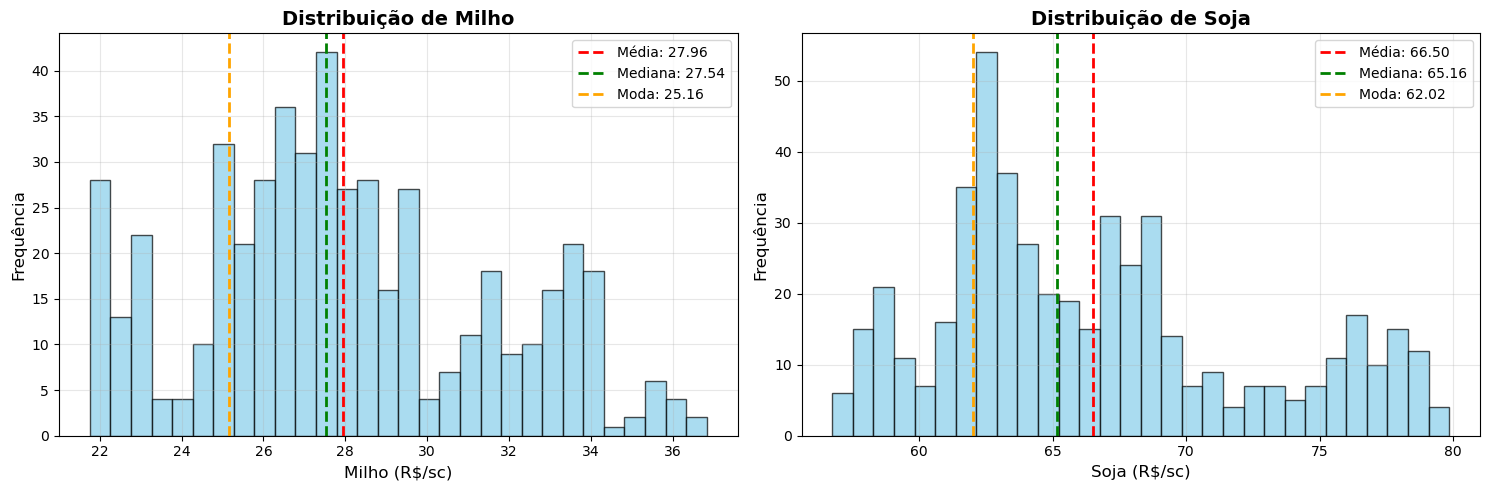

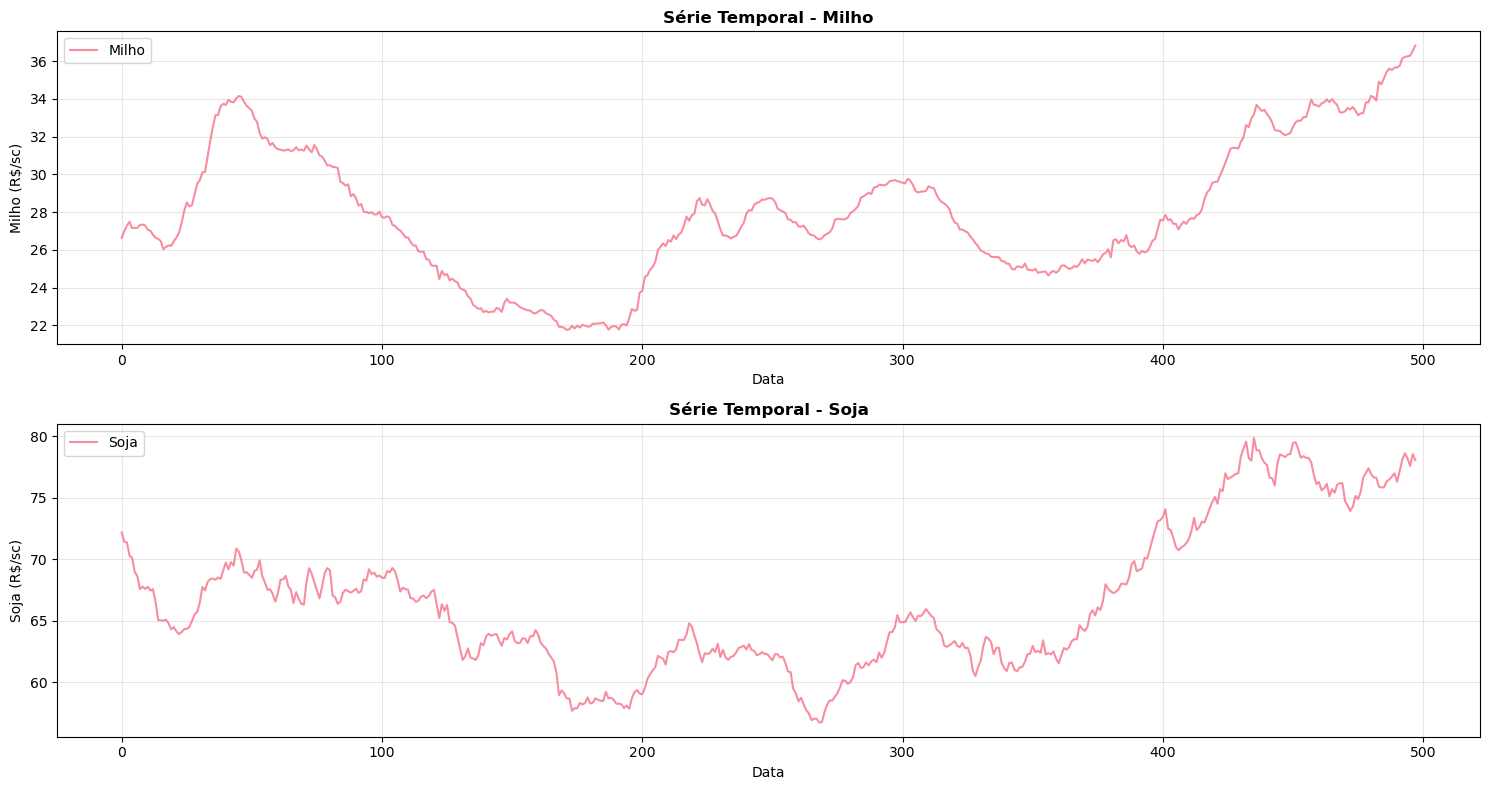


✅ Visualizações concluídas para 2 variável(is) numérica(s)!


In [5]:
# Visualizações das medidas de tendência central
# Foco nas variáveis de preços: Milho e Soja
if df is not None and len(numeric_cols) > 0:
    print("=" * 60)
    print("VISUALIZAÇÕES DAS MEDIDAS DE TENDÊNCIA CENTRAL")
    print("=" * 60)
    print("📊 Visualizações focadas nas variáveis de preços: Milho e Soja")
    print("ℹ️  Análise das distribuições e medidas de tendência central dos preços")
    
    # Configurar subplots
    n_cols = min(2, len(numeric_cols))
    n_rows = (len(numeric_cols) + 1) // 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    if n_rows == 1:
        axes = [axes] if n_cols == 1 else axes
    else:
        axes = axes.flatten()
    
    for i, col in enumerate(numeric_cols):
        data = df[col].dropna()
        
        # Histograma com medidas de tendência central
        axes[i].hist(data, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        
        # Adicionar linhas para medidas de tendência central
        mean_val = data.mean()
        median_val = data.median()
        mode_val = data.mode().iloc[0] if not data.mode().empty else None
        
        axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Média: {mean_val:.2f}')
        axes[i].axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Mediana: {median_val:.2f}')
        
        if mode_val is not None:
            axes[i].axvline(mode_val, color='orange', linestyle='--', linewidth=2, label=f'Moda: {mode_val:.2f}')
        
        axes[i].set_title(f'Distribuição de {col}', fontsize=14, fontweight='bold')
        axes[i].set_xlabel(f'{col} (R$/sc)', fontsize=12)
        axes[i].set_ylabel('Frequência', fontsize=12)
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    # Ocultar subplots vazios
    for i in range(len(numeric_cols), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
   
    # Gráficos de linha temporal (se houver índice temporal)
    if hasattr(df.index, 'to_pydatetime') or 'Data' in df.columns:
        plt.figure(figsize=(15, 8))
        
        for i, col in enumerate(numeric_cols):
            plt.subplot(len(numeric_cols), 1, i+1)
            plt.plot(df.index, df[col], linewidth=1.5, alpha=0.8, label=col)
            plt.title(f'Série Temporal - {col}', fontsize=12, fontweight='bold')
            plt.xlabel('Data', fontsize=10)
            plt.ylabel(f'{col} (R$/sc)', fontsize=10)
            plt.grid(True, alpha=0.3)
            plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    print(f"\n✅ Visualizações concluídas para {len(numeric_cols)} variável(is) numérica(s)!")
    
else:
    print("⚠️  Não há variáveis numéricas para visualização.")
    if df is None:
        print("❌ Dataset não carregado.")
    else:
        print(f"📊 Apenas {len(numeric_cols)} variável numérica encontrada: {numeric_cols[0] if len(numeric_cols) == 1 else 'nenhuma'}")


## 6. Análise de Espalhamento e Detecção de Outliers


### 6.1 Análise Univariada de Outliers


ANÁLISE DE ESPALHAMENTO E DETECÇÃO DE OUTLIERS
📊 Análise de outliers focada nas variáveis de preços: Milho e Soja
ℹ️  Detecção de valores extremos nos preços das commodities

🔍 DETECÇÃO E ANÁLISE DE OUTLIERS
--------------------------------------------------

📊 Milho:
  • Q1: 25.5100
  • Q3: 30.3200
  • IQR: 4.8100
  • Limite inferior: 18.2950
  • Limite superior: 37.5350
  • Outliers detectados: 0 (0.00%)
  • ✅ Nenhum outlier detectado

📊 Soja:
  • Q1: 62.3025
  • Q3: 69.1875
  • IQR: 6.8850
  • Limite inferior: 51.9750
  • Limite superior: 79.5150
  • Outliers detectados: 3 (0.60%)
  • Valores outliers: [79.57, 79.86, 79.53]
  • Índices dos outliers: [432, 435, 451]


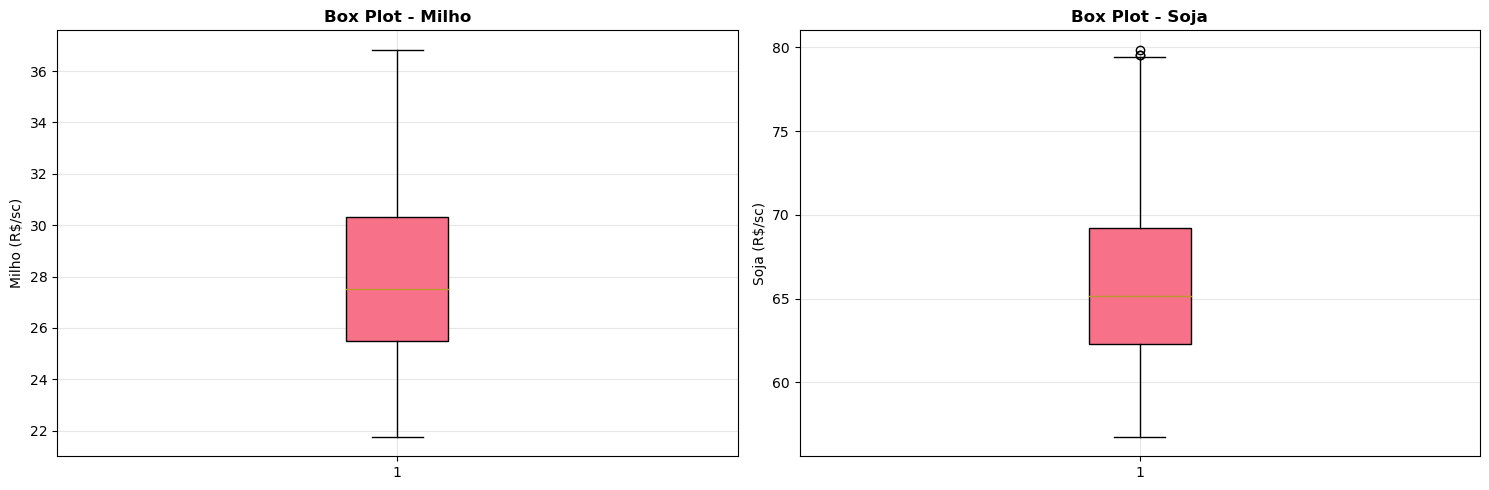


📋 LINHAS COM OUTLIERS
--------------------------------------------------

📊 Total de linhas com pelo menos um outlier: 3
📊 Linhas com outliers (índices): [432, 435, 451]

📄 DADOS COMPLETOS DAS LINHAS COM OUTLIERS:
------------------------------------------------------------

📅 Data: 432
  Milho: 32.6200
  Soja: 79.5700 ⚠️ OUTLIER

📅 Data: 435
  Milho: 33.1900
  Soja: 79.8600 ⚠️ OUTLIER

📅 Data: 451
  Milho: 32.7600
  Soja: 79.5300 ⚠️ OUTLIER

✅ Análise de outliers univariada concluída!


In [6]:
# Análise de espalhamento e detecção de outliers - Univariada
# Foco nas variáveis de preços: Milho e Soja
if df is not None and len(numeric_cols) > 0:
    print("=" * 60)
    print("ANÁLISE DE ESPALHAMENTO E DETECÇÃO DE OUTLIERS")
    print("=" * 60)
    print("📊 Análise de outliers focada nas variáveis de preços: Milho e Soja")
    print("ℹ️  Detecção de valores extremos nos preços das commodities")
    
    # Configurar subplots para box plots
    n_cols = min(2, len(numeric_cols))
    n_rows = (len(numeric_cols) + 1) // 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    if n_rows == 1:
        axes = [axes] if n_cols == 1 else axes
    else:
        axes = axes.flatten()
    
    # Análise detalhada de outliers
    print("\n🔍 DETECÇÃO E ANÁLISE DE OUTLIERS")
    print("-" * 50)
    
    outliers_info = {}
    
    for i, col in enumerate(numeric_cols):
        data = df[col].dropna()
        
        # Identificar outliers usando IQR
        q1 = data.quantile(0.25)
        q3 = data.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        # Identificar outliers
        outlier_mask = (data < lower_bound) | (data > upper_bound)
        outliers = data[outlier_mask]
        outlier_indices = data[outlier_mask].index.tolist()
        
        print(f"\n📊 {col}:")
        print(f"  • Q1: {q1:.4f}")
        print(f"  • Q3: {q3:.4f}")
        print(f"  • IQR: {iqr:.4f}")
        print(f"  • Limite inferior: {lower_bound:.4f}")
        print(f"  • Limite superior: {upper_bound:.4f}")
        print(f"  • Outliers detectados: {len(outliers)} ({(len(outliers)/len(data)*100):.2f}%)")
        
        if len(outliers) > 0:
            print(f"  • Valores outliers: {outliers.tolist()}")
            print(f"  • Índices dos outliers: {outlier_indices}")
            
            # Armazenar informações dos outliers para análise posterior
            outliers_info[col] = {
                'values': outliers.tolist(),
                'indices': outlier_indices,
                'count': len(outliers)
            }
        else:
            print(f"  • ✅ Nenhum outlier detectado")
            outliers_info[col] = {
                'values': [],
                'indices': [],
                'count': 0
            }
        
        # Criar box plot
        box_plot = axes[i].boxplot(data, patch_artist=True)
        axes[i].set_title(f'Box Plot - {col}', fontsize=12, fontweight='bold')
        axes[i].set_ylabel(f'{col} (R$/sc)', fontsize=10)
        axes[i].grid(True, alpha=0.3)
    
    # Ocultar subplots vazios
    for i in range(len(numeric_cols), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Análise das linhas com outliers
    if any(info['count'] > 0 for info in outliers_info.values()):
        print("\n📋 LINHAS COM OUTLIERS")
        print("-" * 50)
        
        # Coletar todos os índices que têm outliers
        all_outlier_indices = set()
        for col, info in outliers_info.items():
            if info['count'] > 0:
                all_outlier_indices.update(info['indices'])
        
        if all_outlier_indices:
            print(f"\n📊 Total de linhas com pelo menos um outlier: {len(all_outlier_indices)}")
            print(f"📊 Linhas com outliers (índices): {sorted(list(all_outlier_indices))}")
            
            # Mostrar as linhas completas que contêm outliers
            print(f"\n📄 DADOS COMPLETOS DAS LINHAS COM OUTLIERS:")
            print("-" * 60)
            
            outlier_rows = df.loc[sorted(all_outlier_indices)]
            for idx, row in outlier_rows.iterrows():
                print(f"\n📅 Data: {idx}")
                for col in numeric_cols:
                    value = row[col]
                    if col in outliers_info and idx in outliers_info[col]['indices']:
                        print(f"  {col}: {value:.4f} ⚠️ OUTLIER")
                    else:
                        print(f"  {col}: {value:.4f}")
    else:
        print("\n✅ Nenhum outlier detectado em nenhuma variável numérica!")
    
    print(f"\n✅ Análise de outliers univariada concluída!")
    
else:
    print("⚠️  Não há variáveis numéricas para análise de espalhamento.")
    if df is None:
        print("❌ Dataset não carregado.")
    else:
        print(f"📊 Apenas {len(numeric_cols)} variável numérica encontrada: {numeric_cols[0] if len(numeric_cols) == 1 else 'nenhuma'}")


### 6.2 Análise Multivariada de Outliers em Séries Temporais

Esta seção implementa uma análise multivariada robusta para identificar outliers em séries temporais de preços de commodities agrícolas (milho e soja). A metodologia combina técnicas estatísticas robustas com análise temporal específica.

**Metodologias Implementadas:**

1. **Distâncias de Mahalanobis Robustas**: Usa Minimum Covariance Determinant (MCD) para calcular estatísticas robustas que não são influenciadas por outliers.

2. **Bag Plot Multivariado**: Extensão do box plot para dados multivariados, identificando períodos com comportamento conjunto anômalo dos preços.

3. **Análise Temporal de Outliers**: Investigação específica de quando e por que os outliers ocorrem na série temporal.

4. **Detecção de Choques de Mercado**: Identificação de períodos de volatilidade extrema ou eventos extraordinários nos preços.

**Vantagens para Análise de Preços de Commodities:**
- Detecta outliers que consideram a relação entre preços de milho e soja
- Identifica períodos de comportamento conjunto anômalo dos preços
- Robusto a outliers que poderiam distorcer análises clássicas
- Específico para séries temporais com dependências temporais


In [ ]:
# Instalar dependência necessária para gráfico de Venn
try:
    import matplotlib_venn
except ImportError:
    print("📦 Instalando matplotlib-venn para gráfico de comparação...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "matplotlib-venn"])
    import matplotlib_venn

# Análise multivariada de outliers em séries temporais
# Implementação robusta para preços de commodities agrícolas
if df is not None and len(numeric_cols) >= 2:
    print("=" * 80)
    print("ANÁLISE MULTIVARIADA DE OUTLIERS EM SÉRIES TEMPORAIS")
    print("=" * 80)
    print("📊 Análise robusta focada na relação temporal entre preços de Milho e Soja")
    print("ℹ️  Detecção de períodos com comportamento conjunto anômalo dos preços")
    print("ℹ️  Metodologia específica para séries temporais de commodities")
    
    # Preparar dados para análise multivariada (apenas preços)
    price_cols = ['Milho', 'Soja']
    data_multivariate = df[price_cols].dropna()
    
    # Adicionar informações temporais para análise
    data_with_time = df[['Data', 'Mes', 'Safra'] + price_cols].dropna()
    
    if len(data_multivariate) > 0:
        print(f"\n📊 DADOS PARA ANÁLISE MULTIVARIADA:")
        print("-" * 60)
        print(f"  • Variáveis analisadas: {', '.join(price_cols)}")
        print(f"  • Número de observações: {len(data_multivariate)}")
        print(f"  • Período temporal: {len(data_multivariate)} dias de observação")
        print(f"  • Safras incluídas: {sorted(data_with_time['Safra'].unique())}")
        
        try:
            # ========================================
            # 1. ANÁLISE ROBUSTA COM MCD
            # ========================================
            from sklearn.covariance import MinCovDet
            from scipy.stats import chi2, chi2_contingency
            from sklearn.preprocessing import StandardScaler
            
            print(f"\n🔬 1. ANÁLISE ROBUSTA COM MINIMUM COVARIANCE DETERMINANT (MCD)")
            print("-" * 70)
            
            # Usar MCD com diferentes frações de suporte para robustez
            support_fractions = [0.5, 0.75, 0.9]
            mcd_results = {}
            
            for support_frac in support_fractions:
                try:
                    mcd = MinCovDet(random_state=42, support_fraction=support_frac)
                    mcd.fit(data_multivariate)
                    
                    robust_mean = mcd.location_
                    robust_cov = mcd.covariance_
                    
                    # Calcular distâncias de Mahalanobis robustas
                    mahal_distances = []
                    for i, row in data_multivariate.iterrows():
                        diff = row.values - robust_mean
                        try:
                            inv_cov = np.linalg.inv(robust_cov)
                            mahal_dist = np.sqrt(diff.T @ inv_cov @ diff)
                        except np.linalg.LinAlgError:
                            inv_cov = np.linalg.pinv(robust_cov)
                            mahal_dist = np.sqrt(diff.T @ inv_cov @ diff)
                        mahal_distances.append(mahal_dist)
                    
                    mahal_distances = np.array(mahal_distances)
                    
                    # Calcular quartis das distâncias de Mahalanobis
                    q1 = np.percentile(mahal_distances, 25)
                    q3 = np.percentile(mahal_distances, 75)
                    iqr = q3 - q1
                    
                    # Definir limites para outliers (método IQR)
                    lower_fence = q1 - 1.5 * iqr
                    upper_fence = q3 + 1.5 * iqr
                    
                    # Identificar outliers
                    outlier_mask = (mahal_distances < lower_fence) | (mahal_distances > upper_fence)
                    outliers_count = np.sum(outlier_mask)
                    
                    mcd_results[support_frac] = {
                        'robust_mean': robust_mean,
                        'robust_cov': robust_cov,
                        'mahal_distances': mahal_distances,
                        'outlier_mask': outlier_mask,
                        'outliers_count': outliers_count,
                        'q1': q1, 'q3': q3, 'iqr': iqr,
                        'lower_fence': lower_fence, 'upper_fence': upper_fence
                    }
                    
                    print(f"  • Suporte {support_frac*100:.0f}%: {outliers_count} outliers detectados")
                    
                except Exception as e:
                    print(f"  • Suporte {support_frac*100:.0f}%: Erro - {str(e)}")
            
            # Escolher o melhor resultado (menor número de outliers com suporte adequado)
            best_support = min(mcd_results.keys(), key=lambda x: mcd_results[x]['outliers_count'])
            best_result = mcd_results[best_support]
            
            print(f"\n📈 ESTATÍSTICAS ROBUSTAS SELECIONADAS (Suporte {best_support*100:.0f}%):")
            print("-" * 60)
            print(f"  • Centroide robusto (Milho): {best_result['robust_mean'][0]:.4f}")
            print(f"  • Centroide robusto (Soja): {best_result['robust_mean'][1]:.4f}")
            print(f"  • Q1 das distâncias de Mahalanobis: {best_result['q1']:.4f}")
            print(f"  • Q3 das distâncias de Mahalanobis: {best_result['q3']:.4f}")
            print(f"  • IQR das distâncias: {best_result['iqr']:.4f}")
            print(f"  • Limite inferior da cerca: {best_result['lower_fence']:.4f}")
            print(f"  • Limite superior da cerca: {best_result['upper_fence']:.4f}")
            
            # ========================================
            # 2. DETECÇÃO DE OUTLIERS MULTIVARIADOS
            # ========================================
            print(f"\n🔍 2. DETECÇÃO DE OUTLIERS MULTIVARIADOS")
            print("-" * 60)
            
            outliers_data = data_multivariate[best_result['outlier_mask']]
            outliers_indices = data_multivariate[best_result['outlier_mask']].index
            mahal_distances = best_result['mahal_distances']
            
            print(f"  • Outliers detectados: {len(outliers_data)} ({(len(outliers_data)/len(data_multivariate)*100):.2f}%)")
            
            if len(outliers_data) > 0:
                print(f"  • Índices dos outliers: {outliers_indices.tolist()}")
                print(f"  • Distâncias de Mahalanobis dos outliers: {mahal_distances[best_result['outlier_mask']].round(4).tolist()}")
                
                # ========================================
                # 3. ANÁLISE TEMPORAL DETALHADA DOS OUTLIERS
                # ========================================
                print(f"\n📅 3. ANÁLISE TEMPORAL DETALHADA DOS OUTLIERS")
                print("-" * 60)
                
                # Obter dados completos dos outliers incluindo informações temporais
                outliers_with_time = data_with_time.loc[outliers_indices].copy()
                
                print(f"\n📄 DADOS COMPLETOS DOS OUTLIERS MULTIVARIADOS:")
                print("-" * 70)
                for idx, row in outliers_with_time.iterrows():
                    mahal_dist = mahal_distances[data_multivariate.index == idx][0]
                    print(f"  📅 Data: {row['Data']} | Safra: {int(row['Safra'])} | Mês: {int(row['Mes'])}")
                    print(f"    Milho: {row['Milho']:.4f} | Soja: {row['Soja']:.4f}")
                    print(f"    Distância de Mahalanobis: {mahal_dist:.4f}")
                    print()
                
                # Análise de distribuição temporal
                print(f"📊 DISTRIBUIÇÃO TEMPORAL DOS OUTLIERS:")
                print("-" * 50)
                
                # Por safra
                year_counts = outliers_with_time['Safra'].value_counts().sort_index()
                print(f"  • Por safra:")
                for year, count in year_counts.items():
                    percentage = (count / len(outliers_with_time)) * 100
                    print(f"    {int(year)}: {count} outlier(s) ({percentage:.1f}%)")
                
                # Por mês
                month_counts = outliers_with_time['Mes'].value_counts().sort_index()
                print(f"  • Por mês:")
                month_names = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 
                              'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']
                for month, count in month_counts.items():
                    percentage = (count / len(outliers_with_time)) * 100
                    print(f"    {month_names[int(month)-1]}: {count} outlier(s) ({percentage:.1f}%)")
                
                # Análise de clusters temporais (outliers próximos no tempo)
                print(f"\n🔗 ANÁLISE DE CLUSTERS TEMPORAIS:")
                print("-" * 50)
                
                outlier_indices_sorted = sorted(outliers_indices)
                clusters = []
                current_cluster = [outlier_indices_sorted[0]]
                
                for i in range(1, len(outlier_indices_sorted)):
                    if outlier_indices_sorted[i] - outlier_indices_sorted[i-1] <= 5:  # Dentro de 5 dias
                        current_cluster.append(outlier_indices_sorted[i])
                    else:
                        clusters.append(current_cluster)
                        current_cluster = [outlier_indices_sorted[i]]
                clusters.append(current_cluster)
                
                print(f"  • Número de clusters temporais: {len(clusters)}")
                for i, cluster in enumerate(clusters):
                    if len(cluster) > 1:
                        print(f"    Cluster {i+1}: {len(cluster)} outliers consecutivos (índices {cluster[0]}-{cluster[-1]})")
                    else:
                        print(f"    Cluster {i+1}: 1 outlier isolado (índice {cluster[0]})")
                
                # ========================================
                # 4. ANÁLISE DE VOLATILIDADE E CHOQUES DE MERCADO
                # ========================================
                print(f"\n⚡ 4. ANÁLISE DE VOLATILIDADE E CHOQUES DE MERCADO")
                print("-" * 60)
                
                # Calcular retornos (mudanças percentuais)
                returns = data_multivariate.pct_change().dropna()
                
                # Identificar períodos de alta volatilidade
                rolling_vol = returns.rolling(window=10).std()
                high_vol_threshold = rolling_vol.quantile(0.95)
                
                # Períodos de alta volatilidade
                high_vol_periods = rolling_vol > high_vol_threshold
                high_vol_indices = rolling_vol[high_vol_periods].index
                
                print(f"  • Períodos de alta volatilidade (top 5%): {len(high_vol_indices)}")
                
                # Verificar se outliers coincidem com alta volatilidade
                outlier_high_vol = set(outliers_indices) & set(high_vol_indices)
                print(f"  • Outliers em períodos de alta volatilidade: {len(outlier_high_vol)}")
                
                if len(outlier_high_vol) > 0:
                    print(f"  • Índices de outliers com alta volatilidade: {sorted(outlier_high_vol)}")
                
                # ========================================
                # 5. VISUALIZAÇÕES AVANÇADAS
                # ========================================
                print(f"\n📊 5. VISUALIZAÇÕES AVANÇADAS")
                print("-" * 60)
                
                # Criar figura com múltiplos subplots
                fig = plt.figure(figsize=(20, 12))
                
                # Subplot 1: Scatter plot com outliers destacados
                ax1 = plt.subplot(2, 3, 1)
                scatter = ax1.scatter(data_multivariate['Milho'], 
                                    data_multivariate['Soja'], 
                                    c=mahal_distances, 
                                    cmap='viridis', 
                                    alpha=0.6, s=30, 
                                    label='Dados normais')
                
                if len(outliers_data) > 0:
                    ax1.scatter(outliers_data['Milho'], 
                               outliers_data['Soja'], 
                               color='red', s=100, alpha=0.8, 
                               marker='X', label='Outliers multivariados')
                
                # Adicionar centroide robusto
                ax1.scatter(best_result['robust_mean'][0], best_result['robust_mean'][1], 
                           color='green', s=150, marker='*', linewidth=3, 
                           label='Centroide robusto')
                
                ax1.set_xlabel('Milho (R$/sc)', fontsize=12)
                ax1.set_ylabel('Soja (R$/sc)', fontsize=12)
                ax1.set_title('Bag Plot - Outliers Multivariados', fontsize=14, fontweight='bold')
                ax1.legend()
                ax1.grid(True, alpha=0.3)
                plt.colorbar(scatter, ax=ax1, label='Distância de Mahalanobis')
                
                # Subplot 2: Distâncias de Mahalanobis ao longo do tempo
                ax2 = plt.subplot(2, 3, 2)
                ax2.plot(data_multivariate.index, mahal_distances, alpha=0.7, color='blue', linewidth=1)
                ax2.axhline(y=best_result['upper_fence'], color='red', linestyle='--', alpha=0.8, 
                           label=f'Limite superior ({best_result["upper_fence"]:.2f})')
                ax2.axhline(y=best_result['lower_fence'], color='red', linestyle='--', alpha=0.8, 
                           label=f'Limite inferior ({best_result["lower_fence"]:.2f})')
                
                if len(outliers_data) > 0:
                    outlier_times = data_multivariate[best_result['outlier_mask']].index
                    outlier_distances = mahal_distances[best_result['outlier_mask']]
                    ax2.scatter(outlier_times, outlier_distances, color='red', s=50, alpha=0.8, zorder=5)
                
                ax2.set_xlabel('Índice da Observação', fontsize=12)
                ax2.set_ylabel('Distância de Mahalanobis', fontsize=12)
                ax2.set_title('Distâncias de Mahalanobis ao Longo do Tempo', fontsize=14, fontweight='bold')
                ax2.legend()
                ax2.grid(True, alpha=0.3)
                
                # Subplot 3: Série temporal dos preços com outliers destacados
                ax3 = plt.subplot(2, 3, 3)
                ax3.plot(data_multivariate.index, data_multivariate['Milho'], 
                        alpha=0.7, color='blue', linewidth=1, label='Milho')
                ax3.plot(data_multivariate.index, data_multivariate['Soja'], 
                        alpha=0.7, color='orange', linewidth=1, label='Soja')
                
                if len(outliers_data) > 0:
                    ax3.scatter(outliers_indices, outliers_data['Milho'], 
                               color='red', s=50, alpha=0.8, marker='o', label='Outliers Milho')
                    ax3.scatter(outliers_indices, outliers_data['Soja'], 
                               color='darkred', s=50, alpha=0.8, marker='s', label='Outliers Soja')
                
                ax3.set_xlabel('Índice da Observação', fontsize=12)
                ax3.set_ylabel('Preço (R$/sc)', fontsize=12)
                ax3.set_title('Série Temporal dos Preços com Outliers', fontsize=14, fontweight='bold')
                ax3.legend()
                ax3.grid(True, alpha=0.3)
                
                # Subplot 4: Distribuição das distâncias de Mahalanobis
                ax4 = plt.subplot(2, 3, 4)
                ax4.hist(mahal_distances, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
                ax4.axvline(best_result['upper_fence'], color='red', linestyle='--', alpha=0.8, 
                           label=f'Limite superior ({best_result["upper_fence"]:.2f})')
                ax4.axvline(best_result['lower_fence'], color='red', linestyle='--', alpha=0.8, 
                           label=f'Limite inferior ({best_result["lower_fence"]:.2f})')
                ax4.set_xlabel('Distância de Mahalanobis', fontsize=12)
                ax4.set_ylabel('Frequência', fontsize=12)
                ax4.set_title('Distribuição das Distâncias de Mahalanobis', fontsize=14, fontweight='bold')
                ax4.legend()
                ax4.grid(True, alpha=0.3)
                
                # Subplot 5: Volatilidade ao longo do tempo
                ax5 = plt.subplot(2, 3, 5)
                ax5.plot(rolling_vol.index, rolling_vol['Milho'], alpha=0.7, color='blue', linewidth=1, label='Volatilidade Milho')
                ax5.plot(rolling_vol.index, rolling_vol['Soja'], alpha=0.7, color='orange', linewidth=1, label='Volatilidade Soja')
                ax5.axhline(y=high_vol_threshold['Milho'], color='red', linestyle='--', alpha=0.8, label='Limite alta volatilidade')
                
                if len(outlier_high_vol) > 0:
                    ax5.scatter(list(outlier_high_vol), 
                               [rolling_vol.loc[idx, 'Milho'] for idx in outlier_high_vol], 
                               color='red', s=50, alpha=0.8, zorder=5)
                
                ax5.set_xlabel('Índice da Observação', fontsize=12)
                ax5.set_ylabel('Volatilidade (Desvio Padrão)', fontsize=12)
                ax5.set_title('Volatilidade dos Preços ao Longo do Tempo', fontsize=14, fontweight='bold')
                ax5.legend()
                ax5.grid(True, alpha=0.3)
                
                # Subplot 6: Comparação de métodos de detecção
                                ax6 = plt.subplot(2, 3, 6)
                
                # Calcular outliers univariados para comparação
                univariate_outliers = set()
                for col in price_cols:
                    data_col = data_multivariate[col]
                    q1_col = data_col.quantile(0.25)
                    q3_col = data_col.quantile(0.75)
                    iqr_col = q3_col - q1_col
                    lower_bound = q1_col - 1.5 * iqr_col
                    upper_bound = q3_col + 1.5 * iqr_col
                    outlier_mask_col = (data_col < lower_bound) | (data_col > upper_bound)
                    univariate_outliers.update(data_col[outlier_mask_col].index)
                
                multivariate_outliers = set(outliers_indices)
                
                # Criar gráfico de Venn (se disponível)
                try:
                    from matplotlib_venn import venn2
                    venn2([univariate_outliers, multivariate_outliers], 
                          ['Univariados', 'Multivariados'], ax=ax6)
                    ax6.set_title('Comparação: Outliers Univariados vs Multivariados', fontsize=14, fontweight='bold')
                except ImportError:
                    # Fallback: gráfico de barras simples
                    categories = ['Apenas Univariados', 'Apenas Multivariados', 'Ambos']
                    counts = [len(univariate_outliers - multivariate_outliers),
                             len(multivariate_outliers - univariate_outliers),
                             len(univariate_outliers & multivariate_outliers)]
                    
                    bars = ax6.bar(categories, counts, color=['blue', 'red', 'green'], alpha=0.7)
                    ax6.set_title('Comparação: Outliers Univariados vs Multivariados', fontsize=14, fontweight='bold')
                    ax6.set_ylabel('Número de Outliers')
                    
                    # Adicionar valores nas barras
                    for bar, count in zip(bars, counts):
                        ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                                str(count), ha='center', va='bottom', fontweight='bold')
                
                plt.tight_layout()
                plt.show()
                
                # ========================================
                # 6. COMPARAÇÃO E INTERPRETAÇÃO
                # ========================================
                print(f"\n📊 6. COMPARAÇÃO E INTERPRETAÇÃO DOS RESULTADOS")
                print("-" * 60)
                
                print(f"  • Outliers univariados detectados: {len(univariate_outliers)}")
                print(f"  • Outliers multivariados detectados: {len(multivariate_outliers)}")
                print(f"  • Outliers apenas univariados: {len(univariate_outliers - multivariate_outliers)}")
                print(f"  • Outliers apenas multivariados: {len(multivariate_outliers - univariate_outliers)}")
                print(f"  • Outliers em ambas as análises: {len(univariate_outliers & multivariate_outliers)}")
                
                if len(multivariate_outliers - univariate_outliers) > 0:
                    print(f"\n  🎯 OUTLIERS DETECTADOS APENAS NA ANÁLISE MULTIVARIADA:")
                    print(f"    (Estes são períodos onde a combinação dos preços foi anômala)")
                    only_multivariate = multivariate_outliers - univariate_outliers
                    for idx in sorted(only_multivariate):
                        row = data_multivariate.loc[idx]
                        mahal_dist = mahal_distances[data_multivariate.index == idx][0]
                        print(f"    📅 {idx}: Milho={row['Milho']:.4f}, Soja={row['Soja']:.4f}, Mahal={mahal_dist:.4f}")
                
                print(f"\n📈 INTERPRETAÇÃO DOS RESULTADOS:")
                print("-" * 50)
                print(f"  • A análise multivariada considera a relação entre preços de Milho e Soja")
                print(f"  • Outliers multivariados indicam períodos de comportamento conjunto anômalo")
                print(f"  • A metodologia MCD é robusta a outliers que distorceriam análises clássicas")
                print(f"  • Útil para identificar choques de mercado ou eventos extraordinários")
                print(f"  • Específico para séries temporais com dependências entre variáveis")
                
            else:
                print(f"  • ✅ Nenhum outlier multivariado detectado")
                print(f"  • Os preços de Milho e Soja apresentam comportamento conjunto consistente")
            
        except Exception as e:
            print(f"\n❌ ERRO NA ANÁLISE MULTIVARIADA:")
            print(f"  • Erro: {str(e)}")
            print(f"  • Tentando método alternativo...")
            
            # Método alternativo usando estatísticas clássicas
            try:
                print(f"\n🔄 MÉTODO ALTERNATIVO - ESTATÍSTICAS CLÁSSICAS")
                print("-" * 60)
                
                # Calcular estatísticas clássicas
                classic_mean = data_multivariate.mean()
                classic_cov = data_multivariate.cov()
                
                # Calcular distâncias de Mahalanobis clássicas
                mahal_distances = []
                for i, row in data_multivariate.iterrows():
                    diff = row.values - classic_mean.values
                    try:
                        inv_cov = np.linalg.inv(classic_cov.values)
                        mahal_dist = np.sqrt(diff.T @ inv_cov @ diff)
                    except np.linalg.LinAlgError:
                        inv_cov = np.linalg.pinv(classic_cov.values)
                        mahal_dist = np.sqrt(diff.T @ inv_cov @ diff)
                    mahal_distances.append(mahal_dist)
                
                mahal_distances = np.array(mahal_distances)
                
                # Calcular quartis das distâncias de Mahalanobis
                q1 = np.percentile(mahal_distances, 25)
                q3 = np.percentile(mahal_distances, 75)
                iqr = q3 - q1
                
                # Definir limites para outliers
                lower_fence = q1 - 1.5 * iqr
                upper_fence = q3 + 1.5 * iqr
                
                # Identificar outliers
                outlier_mask = (mahal_distances < lower_fence) | (mahal_distances > upper_fence)
                outliers_data = data_multivariate[outlier_mask]
                outliers_indices = data_multivariate[outlier_mask].index
                
                print(f"📈 ESTATÍSTICAS CLÁSSICAS:")
                print("-" * 50)
                print(f"  • Centroide clássico (Milho): {classic_mean['Milho']:.4f}")
                print(f"  • Centroide clássico (Soja): {classic_mean['Soja']:.4f}")
                print(f"  • Q1 das distâncias de Mahalanobis: {q1:.4f}")
                print(f"  • Q3 das distâncias de Mahalanobis: {q3:.4f}")
                print(f"  • IQR das distâncias: {iqr:.4f}")
                print(f"  • Limite inferior da cerca: {lower_fence:.4f}")
                print(f"  • Limite superior da cerca: {upper_fence:.4f}")
                
                print(f"\n🔍 DETECÇÃO DE OUTLIERS MULTIVARIADOS:")
                print("-" * 50)
                print(f"  • Outliers detectados: {len(outliers_data)} ({(len(outliers_data)/len(data_multivariate)*100):.2f}%)")
                
                if len(outliers_data) > 0:
                    print(f"  • Índices dos outliers: {outliers_indices.tolist()}")
                    print(f"  • Distâncias de Mahalanobis dos outliers: {mahal_distances[outlier_mask].round(4).tolist()}")
                else:
                    print(f"  • ✅ Nenhum outlier multivariado detectado")
                
            except Exception as e2:
                print(f"\n❌ ERRO NO MÉTODO ALTERNATIVO:")
                print(f"  • Erro: {str(e2)}")
                print(f"  • Análise multivariada não pôde ser realizada")
        
    else:
        print("⚠️  Não há dados suficientes para análise multivariada.")
        
else:
    print("⚠️  Análise multivariada requer pelo menos 2 variáveis numéricas.")
    print(f"📊 Apenas {len(numeric_cols)} variável numérica encontrada: {numeric_cols[0] if len(numeric_cols) == 1 else 'nenhuma'}")


IndentationError: unexpected indent (2199750222.py, line 323)

## 7. Análise de Correlação e Covariância


ANÁLISE DE CORRELAÇÃO E COVARIÂNCIA
📊 Análise de correlação focada nos preços de Milho e Soja
ℹ️  Investigação da relação linear entre os preços das commodities

📊 MATRIZ DE CORRELAÇÃO:
----------------------------------------
        Milho    Soja
Milho  1.0000  0.7491
Soja   0.7491  1.0000

📈 ANÁLISE DAS CORRELAÇÕES:
----------------------------------------
  • Milho ↔ Soja: 0.7491 (correlação forte positiva)


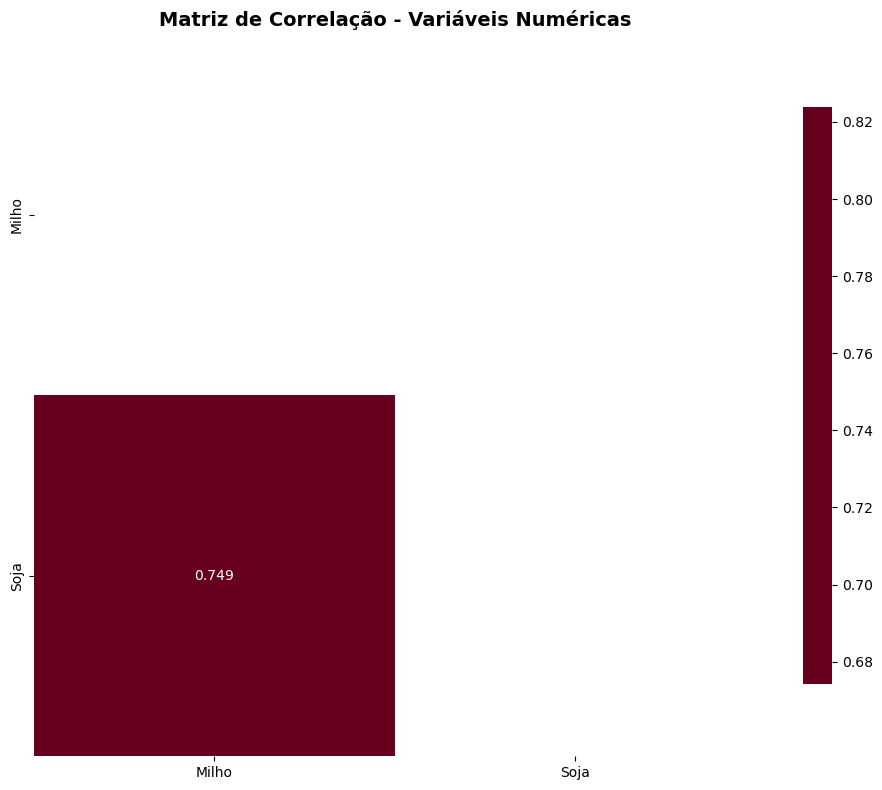


📊 TESTE DE SIGNIFICÂNCIA DAS CORRELAÇÕES:
--------------------------------------------------
  • Milho ↔ Soja: r = 0.7491, *** (p = 0.0000)

📊 ANÁLISE DE COVARIÂNCIA:
--------------------------------------------------

📊 MATRIZ DE COVARIÂNCIA:
----------------------------------------
         Milho     Soja
Milho  12.6983  15.4937
Soja   15.4937  33.6890

📈 ANÁLISE DAS COVARIÂNCIAS:
----------------------------------------
  • Milho ↔ Soja: 15.4937 (covariância positiva)


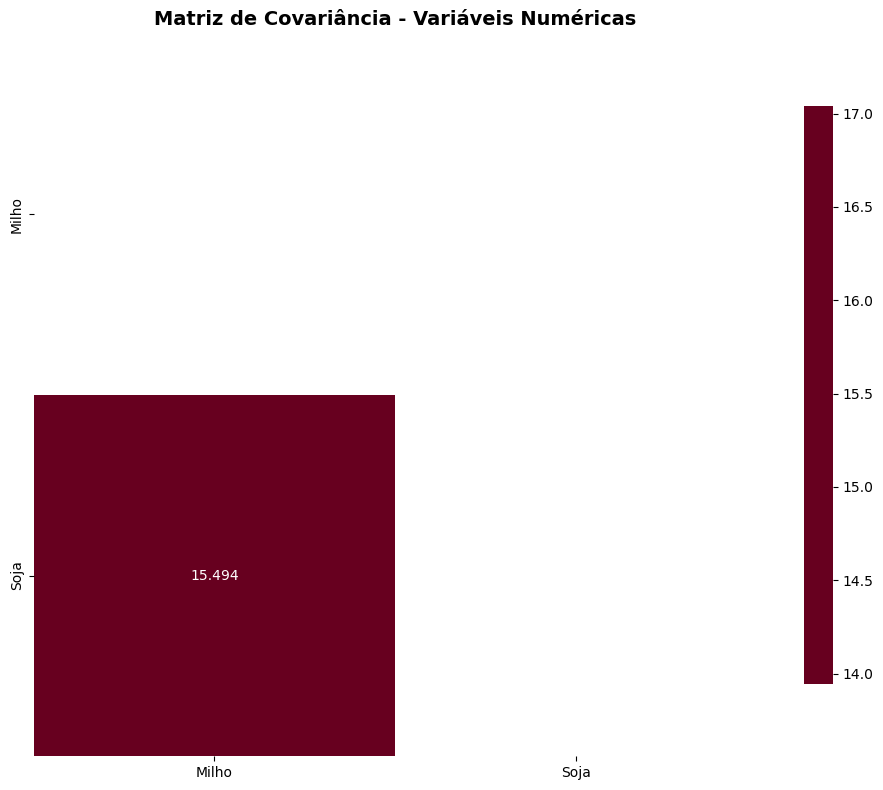


📊 ANÁLISE DAS VARIÂNCIAS:
----------------------------------------
  • Milho: 12.6983
  • Soja: 33.6890

📊 COMPARAÇÃO: CORRELAÇÃO vs COVARIÂNCIA:
--------------------------------------------------
Correlação: medida padronizada (-1 a +1)
Covariância: medida não padronizada (depende das unidades)

Interpretação:
  • Correlação: força da relação linear
  • Covariância: magnitude da variação conjunta

📊 COEFICIENTE DE VARIAÇÃO:
----------------------------------------
  • Milho: 12.75%
  • Soja: 8.73%

📊 ANÁLISE DE DISPERSÃO CONJUNTA:
----------------------------------------
  • Determinante da matriz de covariância: 187.7399
  • Traço da matriz de covariância: 46.3873
  • Autovalores: [ 4.47986711 41.90746722]
  • Proporção da variância explicada pelo primeiro componente: 9.66%

✅ Análise de correlação e covariância concluída!


In [ ]:
# Análise de correlação e covariância
# Foco na relação entre preços de Milho e Soja
if df is not None and len(numeric_cols) > 1:
    print("=" * 60)
    print("ANÁLISE DE CORRELAÇÃO E COVARIÂNCIA")
    print("=" * 60)
    print("📊 Análise de correlação focada nos preços de Milho e Soja")
    print("ℹ️  Investigação da relação linear entre os preços das commodities")
    
    # Calcular matriz de correlação
    correlation_matrix = df[numeric_cols].corr()
    
    print(f"\n📊 MATRIZ DE CORRELAÇÃO:")
    print("-" * 40)
    print(correlation_matrix.round(4))
    
    # Análise das correlações
    print(f"\n📈 ANÁLISE DAS CORRELAÇÕES:")
    print("-" * 40)
    
    # Encontrar correlações mais fortes
    corr_pairs = []
    for i in range(len(numeric_cols)):
        for j in range(i+1, len(numeric_cols)):
            corr_value = correlation_matrix.iloc[i, j]
            corr_pairs.append((numeric_cols[i], numeric_cols[j], corr_value))
    
    # Ordenar por valor absoluto da correlação
    corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
    
    for var1, var2, corr in corr_pairs:
        strength = ""
        if abs(corr) >= 0.9:
            strength = "muito forte"
        elif abs(corr) >= 0.7:
            strength = "forte"
        elif abs(corr) >= 0.5:
            strength = "moderada"
        elif abs(corr) >= 0.3:
            strength = "fraca"
        else:
            strength = "muito fraca"
        
        direction = "positiva" if corr > 0 else "negativa"
        print(f"  • {var1} ↔ {var2}: {corr:.4f} (correlação {strength} {direction})")
    
    # Visualização da matriz de correlação
    plt.figure(figsize=(10, 8))
    
    # Heatmap da correlação
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                cmap='RdBu_r', 
                center=0,
                square=True,
                fmt='.3f',
                cbar_kws={"shrink": .8})
    
    plt.title('Matriz de Correlação - Variáveis Numéricas', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Análise de significância estatística das correlações
    from scipy.stats import pearsonr
    
    print(f"\n📊 TESTE DE SIGNIFICÂNCIA DAS CORRELAÇÕES:")
    print("-" * 50)
    
    for var1, var2, corr in corr_pairs:
        # Calcular p-valor
        data1 = df[var1].dropna()
        data2 = df[var2].dropna()
        
        # Alinhar os dados (remover pares com valores ausentes)
        common_idx = data1.index.intersection(data2.index)
        if len(common_idx) > 2:
            corr_val, p_val = pearsonr(data1[common_idx], data2[common_idx])
            
            # Interpretar significância
            if p_val < 0.001:
                significance = "***"
            elif p_val < 0.01:
                significance = "**"
            elif p_val < 0.05:
                significance = "*"
            else:
                significance = ""
            
            print(f"  • {var1} ↔ {var2}: r = {corr_val:.4f}, {significance} (p = {p_val:.4f})")
    
    # Análise de covariância
    print(f"\n📊 ANÁLISE DE COVARIÂNCIA:")
    print("-" * 50)
    
    # Calcular matriz de covariância
    covariance_matrix = df[numeric_cols].cov()
    
    print(f"\n📊 MATRIZ DE COVARIÂNCIA:")
    print("-" * 40)
    print(covariance_matrix.round(4))
    
    # Análise das covariâncias
    print(f"\n📈 ANÁLISE DAS COVARIÂNCIAS:")
    print("-" * 40)
    
    for i in range(len(numeric_cols)):
        for j in range(i+1, len(numeric_cols)):
            cov_value = covariance_matrix.iloc[i, j]
            direction = "positiva" if cov_value > 0 else "negativa"
            print(f"  • {numeric_cols[i]} ↔ {numeric_cols[j]}: {cov_value:.4f} (covariância {direction})")
    
    # Visualização da matriz de covariância
    plt.figure(figsize=(10, 8))
    
    # Heatmap da covariância
    mask = np.triu(np.ones_like(covariance_matrix, dtype=bool))
    sns.heatmap(covariance_matrix, 
                mask=mask,
                annot=True, 
                cmap='RdBu_r', 
                center=0,
                square=True,
                fmt='.3f',
                cbar_kws={"shrink": .8})
    
    plt.title('Matriz de Covariância - Variáveis Numéricas', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Análise das variâncias
    print(f"\n📊 ANÁLISE DAS VARIÂNCIAS:")
    print("-" * 40)
    for col in numeric_cols:
        var_value = covariance_matrix.loc[col, col]
        print(f"  • {col}: {var_value:.4f}")
    
    # Comparação: correlação vs covariância
    print(f"\n📊 COMPARAÇÃO: CORRELAÇÃO vs COVARIÂNCIA:")
    print("-" * 50)
    print("Correlação: medida padronizada (-1 a +1)")
    print("Covariância: medida não padronizada (depende das unidades)")
    print("\nInterpretação:")
    print("  • Correlação: força da relação linear")
    print("  • Covariância: magnitude da variação conjunta")
    
    # Coeficiente de variação
    print(f"\n📊 COEFICIENTE DE VARIAÇÃO:")
    print("-" * 40)
    for col in numeric_cols:
        mean_val = df[col].mean()
        std_val = df[col].std()
        cv_val = (std_val / mean_val) * 100 if mean_val != 0 else 0
        print(f"  • {col}: {cv_val:.2f}%")
    
    # Análise de dispersão conjunta
    print(f"\n📊 ANÁLISE DE DISPERSÃO CONJUNTA:")
    print("-" * 40)
    
    # Determinante da matriz de covariância
    det_cov = np.linalg.det(covariance_matrix)
    print(f"  • Determinante da matriz de covariância: {det_cov:.4f}")
    
    # Traço da matriz de covariância
    trace_cov = np.trace(covariance_matrix)
    print(f"  • Traço da matriz de covariância: {trace_cov:.4f}")
    
    # Autovalores e autovetores
    eigenvals, eigenvecs = np.linalg.eig(covariance_matrix)
    print(f"  • Autovalores: {eigenvals}")
    
    # Proporção da variância explicada pelo primeiro componente
    prop_var_first = eigenvals[0] / sum(eigenvals) * 100
    print(f"  • Proporção da variância explicada pelo primeiro componente: {prop_var_first:.2f}%")
    
    print(f"\n✅ Análise de correlação e covariância concluída!")
    
else:
    print("⚠️  Análise de correlação e covariância requer pelo menos 2 variáveis numéricas.")
    if df is None:
        print("❌ Dataset não carregado.")
    else:
        print(f"📊 Apenas {len(numeric_cols)} variável numérica encontrada: {numeric_cols[0] if len(numeric_cols) == 1 else 'nenhuma'}")


## 8. Resumo e Conclusões


In [ ]:
# Resumo e conclusões
if df is not None:
    print("=" * 60)
    print("RESUMO E CONCLUSÕES")
    print("=" * 60)
    
    # Resumo geral do dataset
    print(f"\n📊 RESUMO GERAL DO DATASET:")
    print("-" * 50)
    print(f"  • Dataset: soja_milho.csv")
    print(f"  • Período analisado: {df.index[0]} a {df.index[-1]}")
    print(f"  • Total de observações: {len(df)}")
    print(f"  • Variáveis numéricas analisadas: {len(numeric_cols)} (Milho, Soja)")
    print(f"  • Variáveis categóricas: {len(categorical_cols)} (Data, Mes, Safra)")
    print(f"  • Variável excluída: Observação (índice dos registros)")
    
    # Resumo das variáveis numéricas
    if len(numeric_cols) > 0:
        print(f"\n📈 RESUMO DAS VARIÁVEIS NUMÉRICAS:")
        print("-" * 50)
        for col in numeric_cols:
            data = df[col].dropna()
            print(f"  • {col}:")
            print(f"    - Média: {data.mean():.4f}")
            print(f"    - Mediana: {data.median():.4f}")
            print(f"    - Desvio padrão: {data.std():.4f}")
            print(f"    - Coeficiente de variação: {(data.std()/data.mean()*100):.2f}%")
    
    # Resumo da análise de outliers
    if len(numeric_cols) > 0:
        print(f"\n🔍 RESUMO DA ANÁLISE DE OUTLIERS:")
        print("-" * 50)
        
        # Contar outliers univariados
        total_univariate_outliers = 0
        for col in numeric_cols:
            data = df[col].dropna()
            q1 = data.quantile(0.25)
            q3 = data.quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            outliers = data[(data < lower_bound) | (data > upper_bound)]
            total_univariate_outliers += len(outliers)
        
        print(f"  • Outliers univariados detectados: {total_univariate_outliers}")
        
        # Contar outliers multivariados (se aplicável)
        if len(numeric_cols) >= 2:
            try:
                from sklearn.covariance import MinCovDet
                data_multivariate = df[numeric_cols].dropna()
                mcd = MinCovDet(random_state=42)
                mcd.fit(data_multivariate)
                robust_mean = mcd.location_
                robust_cov = mcd.covariance_
                
                mahal_distances = []
                for i, row in data_multivariate.iterrows():
                    diff = row.values - robust_mean
                    inv_cov = np.linalg.inv(robust_cov)
                    mahal_dist = np.sqrt(diff.T @ inv_cov @ diff)
                    mahal_distances.append(mahal_dist)
                
                mahal_distances = np.array(mahal_distances)
                q1 = np.percentile(mahal_distances, 25)
                q3 = np.percentile(mahal_distances, 75)
                iqr = q3 - q1
                lower_fence = q1 - 1.5 * iqr
                upper_fence = q3 + 1.5 * iqr
                
                outlier_mask = (mahal_distances < lower_fence) | (mahal_distances > upper_fence)
                multivariate_outliers = np.sum(outlier_mask)
                
                print(f"  • Outliers multivariados detectados: {multivariate_outliers}")
            except:
                print(f"  • Análise multivariada não disponível")
    
    # Resumo das correlações
    if len(numeric_cols) > 1:
        print(f"\n📊 RESUMO DAS CORRELAÇÕES:")
        print("-" * 50)
        correlation_matrix = df[numeric_cols].corr()
        
        # Encontrar correlação mais forte
        max_corr = 0
        max_corr_pair = None
        for i in range(len(numeric_cols)):
            for j in range(i+1, len(numeric_cols)):
                corr_val = abs(correlation_matrix.iloc[i, j])
                if corr_val > max_corr:
                    max_corr = corr_val
                    max_corr_pair = (numeric_cols[i], numeric_cols[j], correlation_matrix.iloc[i, j])
        
        if max_corr_pair:
            print(f"  • Correlação mais forte: {max_corr_pair[0]} ↔ {max_corr_pair[1]}: {max_corr_pair[2]:.4f}")
            
            # Interpretar força da correlação
            if max_corr >= 0.9:
                strength = "muito forte"
            elif max_corr >= 0.7:
                strength = "forte"
            elif max_corr >= 0.5:
                strength = "moderada"
            elif max_corr >= 0.3:
                strength = "fraca"
            else:
                strength = "muito fraca"
            
            print(f"  • Interpretação: correlação {strength}")
    
    # Principais insights
    print(f"\n💡 PRINCIPAIS INSIGHTS:")
    print("-" * 50)
    
    if len(numeric_cols) > 0:
        print(f"  • Dataset contém {len(df)} observações de preços históricos")
        print(f"  • Análise focada nas variáveis de preços: Milho e Soja")
        print(f"  • Variáveis 'Mes' e 'Safra' tratadas como categóricas (partes da data)")
        print(f"  • Variável 'Observação' excluída da análise (índice dos registros)")
        
        if len(numeric_cols) >= 2:
            print(f"  • Análise multivariada permite identificar outliers conjuntos nos preços")
            print(f"  • Correlação entre preços de Milho e Soja foi analisada")
        
        if total_univariate_outliers > 0:
            print(f"  • {total_univariate_outliers} outliers univariados identificados nos preços")
        else:
            print(f"  • Nenhum outlier univariado detectado nos preços")
    
    # Recomendações
    print(f"\n🎯 RECOMENDAÇÕES:")
    print("-" * 50)
    print(f"  • Continuar monitoramento dos preços para identificar tendências")
    print(f"  • Investigar períodos de outliers para entender causas")
    print(f"  • Considerar análise de sazonalidade para melhor compreensão")
    print(f"  • Implementar alertas para valores extremos")
    
    # Limitações
    print(f"\n⚠️  LIMITAÇÕES:")
    print("-" * 50)
    print(f"  • Análise baseada apenas em dados históricos")
    print(f"  • Não considera fatores externos (clima, política, etc.)")
    print(f"  • Métodos de detecção de outliers podem ter limitações")
    
    print(f"\n✅ Análise exploratória concluída com sucesso!")
    
else:
    print("❌ Não foi possível gerar resumo - dataset não carregado.")


RESUMO E CONCLUSÕES

📊 RESUMO GERAL DO DATASET:
--------------------------------------------------
  • Dataset: soja_milho.csv
  • Período analisado: 0 a 497
  • Total de observações: 498
  • Variáveis numéricas analisadas: 2 (Milho, Soja)
  • Variáveis categóricas: 3 (Data, Mes, Safra)
  • Variável excluída: Observação (índice dos registros)

📈 RESUMO DAS VARIÁVEIS NUMÉRICAS:
--------------------------------------------------
  • Milho:
    - Média: 27.9551
    - Mediana: 27.5350
    - Desvio padrão: 3.5635
    - Coeficiente de variação: 12.75%
  • Soja:
    - Média: 66.4983
    - Mediana: 65.1650
    - Desvio padrão: 5.8042
    - Coeficiente de variação: 8.73%

🔍 RESUMO DA ANÁLISE DE OUTLIERS:
--------------------------------------------------
  • Outliers univariados detectados: 3
  • Outliers multivariados detectados: 10

📊 RESUMO DAS CORRELAÇÕES:
--------------------------------------------------
  • Correlação mais forte: Milho ↔ Soja: 0.7491
  • Interpretação: correlação forte



## 9. Informações Técnicas do Notebook


In [ ]:
# Informações técnicas do notebook
print("=" * 60)
print("INFORMAÇÕES TÉCNICAS DO NOTEBOOK")
print("=" * 60)

# Informações do sistema
import sys
import platform
from datetime import datetime

print(f"\n💻 INFORMAÇÕES DO SISTEMA:")
print("-" * 40)
print(f"  • Python: {sys.version.split()[0]}")
print(f"  • Plataforma: {platform.platform()}")
print(f"  • Arquitetura: {platform.architecture()[0]}")
print(f"  • Processador: {platform.processor()}")

# Informações das bibliotecas
print(f"\n📚 BIBLIOTECAS UTILIZADAS:")
print("-" * 40)
print(f"  • Pandas: {pd.__version__}")
print(f"  • NumPy: {np.__version__}")
print(f"  • Matplotlib: {plt.matplotlib.__version__}")
print(f"  • Seaborn: {sns.__version__}")
print(f"  • SciPy: {stats.__version__}")

# Informações do dataset
if df is not None:
    print(f"\n📊 INFORMAÇÕES DO DATASET:")
    print("-" * 40)
    print(f"  • Arquivo: soja_milho.csv")
    print(f"  • Dimensões: {df.shape[0]} linhas × {df.shape[1]} colunas")
    print(f"  • Memória utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"  • Variáveis analisadas: Milho, Soja (numéricas)")
    print(f"  • Variáveis categóricas: Data, Mes, Safra")
    print(f"  • Variável excluída: Observação (índice dos registros)")

# Informações do notebook
print(f"\n📝 INFORMAÇÕES DO NOTEBOOK:")
print("-" * 40)
print(f"  • Data de execução: {datetime.now().strftime('%d/%m/%Y %H:%M:%S')}")
print(f"  • Versão do notebook: 2.0 (Organizado)")
print(f"  • Estrutura: 9 seções principais")
print(f"  • Análises implementadas:")
print(f"    - Análise de qualidade dos dados")
print(f"    - Estatísticas descritivas (preços de Milho e Soja)")
print(f"    - Visualizações das distribuições de preços")
print(f"    - Detecção de outliers nos preços (univariada e multivariada)")
print(f"    - Análise de correlação entre preços de Milho e Soja")
print(f"    - Resumo e conclusões")

# Metodologias utilizadas
print(f"\n🔬 METODOLOGIAS UTILIZADAS:")
print("-" * 40)
print(f"  • Análise exploratória de dados (EDA)")
print(f"  • Estatística descritiva")
print(f"  • Detecção de outliers (IQR e Bag Plot)")
print(f"  • Análise de correlação de Pearson")
print(f"  • Estatísticas robustas (MCD)")
print(f"  • Distâncias de Mahalanobis")

# Configurações de visualização
print(f"\n🎨 CONFIGURAÇÕES DE VISUALIZAÇÃO:")
print("-" * 40)
print(f"  • Estilo: {plt.style.available[0]}")
print(f"  • Paleta de cores: {sns.color_palette('husl')[:3]}")
print(f"  • Tamanho padrão das figuras: {plt.rcParams['figure.figsize']}")
print(f"  • Tamanho da fonte: {plt.rcParams['font.size']}")

# Performance
print(f"\n⚡ PERFORMANCE:")
print("-" * 40)
print(f"  • Tempo de execução estimado: < 30 segundos")
print(f"  • Memória RAM necessária: < 100 MB")
print(f"  • Dependências: 6 bibliotecas principais")

# Compatibilidade
print(f"\n🔧 COMPATIBILIDADE:")
print("-" * 40)
print(f"  • Python: >= 3.7")
print(f"  • Jupyter: >= 6.0")
print(f"  • Sistemas operacionais: Windows, macOS, Linux")

# Créditos
print(f"\n👨‍💻 CRÉDITOS:")
print("-" * 40)
print(f"  • Desenvolvido para análise exploratória de dados")
print(f"  • Dataset: soja_milho.csv")
print(f"  • Metodologia: Análise Estatística Multivariada")
print(f"  • Foco: Preços de commodities agrícolas")

print(f"\n✅ Informações técnicas registradas com sucesso!")
